In [1]:
import neuron
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

h.load_file('stdrun.hoc')
neuron.load_mechanisms('mechanisms')
h.load_file('templates/templates.hoc') # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.celsius = 36.0

In [2]:
Connection = 'CP2CP'
settings = {
    'post_cell': 'CP_Cell',
    'sec_id': 1,
    'sec_x': 0.4,
    'syn_type': 'AMPA_NMDA_STP',
    'vclamp': True,
    'vclamp_amp': -60,
    'tstart': 500,
    'tdur': 1500,
    'threshold': 0, # netcon
    'delay': 1.6, # netcon
    'weight': 1, # netcon
    'syn_param': {
        'initW': 1.0,
        'tau_r_AMPA': 0.2, # (ms) Dual-exponential conductance profile
        'tau_d_AMPA': 1.7, # (ms) IMPORTANT: tau_r < tau_d
        'tau_r_NMDA': 0.29, # (ms) Dual-exponential conductance profile
        'tau_d_NMDA': 43, # (ms) IMPORTANT: tau_r < tau_d
        'gmax_NMDA': 0.001, # (uS) Weight conversion factor (from nS to uS)
        'gmax_AMPA': 0.001, # (uS)
        'Use': 1.0, # (1) Utilization of synaptic efficacy
        'Dep': 100, # (ms) Relaxation time constant from depression
        'Fac': 10, # (ms) Relaxation time constant from facilitation
        'u0': 0 # Initial value of u, which is the running value of Use
    }
}

In [3]:
tstart = settings['tstart']
tdur = settings['tdur']
h.tstop = tstop = tstart + tdur # how long to run the simulation in ms

cell = getattr(h, settings['post_cell'])()
syn = getattr(h,settings['syn_type'])(list(cell.all)[settings['sec_id']](settings['sec_x']))
nstim = h.NetStim()
nstim.start = tstart
nstim.noise = 0
nc = h.NetCon(nstim, syn, settings['threshold'], settings['delay'], settings['weight'])
vcl = h.VClamp(cell.soma[0](0.5))
vcldur = [[0, 0, 0],[tstart, tstop, 1e9]]
for i in range(3):
    vcl.amp[i] = settings['vclamp_amp']

def switch_vclamp(on=True):
    on = int(on)
    for i in range(3):
        vcl.dur[i] = vcldur[on][i]

switch_vclamp(settings['vclamp'])

t = h.Vector() # Vectors are used to record data in the simulation
soma_v = h.Vector()
isyn = h.Vector()
Use_rec = h.Vector()
Pr = h.Vector()
soma_v.record(cell.soma[0](0.5)._ref_v)
isyn.record(syn._ref_i)
Pr.record(syn._ref_record_Pr)
Use_rec.record(syn._ref_record_use)

t.record(h._ref_t) # derefences and records data

def plot_model(xlim=[]):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.ravel()
    axs[0].plot(t, soma_v)
    axs[0].set_title('Soma Voltage')
    axs[1].plot(t, isyn)
    axs[1].set_title('Synaptic Current')
    axs[2].plot(t, Use_rec)
    axs[2].set_title('Running Synaptic Efficacy')
    axs[3].plot(t, Pr)
    axs[3].set_title('Release Probability')
    for ax in axs:
        ax.set_xlim(*xlim)
    plt.show()

In [4]:
settings['syn_param'] = {
    'initW': 1.0,
    'tau_r_AMPA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_AMPA': 1.7, # (ms) IMPORTANT: tau_r < tau_d
    'tau_r_NMDA': 0.29, # (ms) Dual-exponential conductance profile
    'tau_d_NMDA': 43, # (ms) IMPORTANT: tau_r < tau_d
    'gmax_NMDA': 0.001, # (uS) Weight conversion factor (from nS to uS)
    'gmax_AMPA': 0.001, # (uS)
    'Use': 1.0, # (1) Utilization of synaptic efficacy
    'Dep': 100, # (ms) Relaxation time constant from depression
    'Fac': 10, # (ms) Relaxation time constant from facilitation
    'u0': 0 # Initial value of u, which is the running value of Use
}

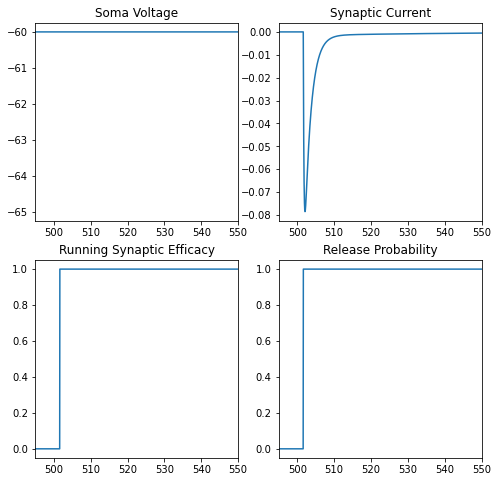

In [5]:
nstim.interval = tdur
nstim.number = 1
for key, value in settings['syn_param'].items():
    setattr(syn, key, value)

h.run()

plot_model([tstart - 5, tstart + 50])

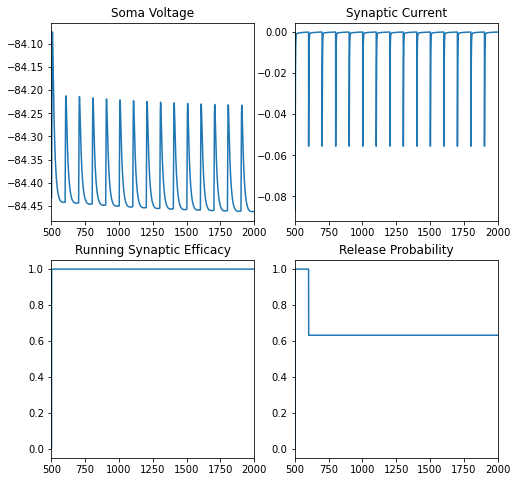

In [6]:
def model(weight, input_frequency, Use, tau_f, tau_d):
    nstim.interval = 1000 / input_frequency
    nstim.number = np.ceil(tdur / 1000 * input_frequency + 1)
    syn.initW = weight #synaptic weight for our synapse
    syn.Fac = tau_f
    syn.Dep = tau_d
    syn.Use = Use
    
    h.finitialize(cell.Vinit * mV)
    h.continuerun(tstop * ms)
    plot_model([tstart, tstop])

syn_param = settings['syn_param']

w_run = widgets.Button(description='Run', icon='history', button_style='primary')
w_vclamp = widgets.ToggleButton(value=settings['vclamp'], description='Voltage Clamp', icon='check', button_style='primary')
w_weight = widgets.FloatSlider(value=syn_param['initW'], min=0., max=100., step=1e-3, description='Syn Weight')
w_input_freq = widgets.FloatSlider(value=10, min=1., max=100., step=1, description='Input Freq')
w_Use = widgets.FloatSlider(value=syn_param['Use'], min=0.,max=1., step=1e-3, description='Init Efficacy')
w_tau_f = widgets.FloatSlider(value=syn_param['Fac'], min=0, max=500, step=1, description='tau fac')
w_tau_d = widgets.FloatSlider(value=syn_param['Dep'], min=0, max=500, step=1, description='tau dep')

def run_model(*arges):
    clear_output()
    display(ui)
    switch_vclamp(w_vclamp.value)
    model(w_weight.value, w_input_freq.value, w_Use.value, w_tau_f.value, w_tau_d.value)
    
w_run.on_click(run_model) 
ui = VBox([HBox([w_run, w_vclamp]), w_weight, HBox([w_input_freq, w_Use]), HBox([w_tau_d, w_tau_f])])
display(ui)